In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import glob
import os
import re
import pandas as pd
import tarfile
import P4J
from astropy.table import Table
from astropy.stats import sigma_clip
#from metric_tools import *
from astroML.time_series import MultiTermFit
from astropy.stats import sigma_clip
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel as C

%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)
sns.set(style="whitegrid", color_codes=True, context="poster")

mainpath = '/Users/jorgetil/Astro/HITS'

ImportError: cannot import name GaussianProcessRegressor

In [3]:
def multi_term_fit(time, mag, err, T, plot=False):
    mtf = MultiTermFit(2*np.pi/T, 4)
    mtf.fit(time, mag, err)
    phase_fit, y_fit, phased_t = mtf.predict(1000, return_phased_times=True)

    if plot:
        plt.figure(figsize=(9,4))
        plt.plot(phase_fit, y_fit, 'r-')
        plt.plot(phase_fit+1, y_fit, 'r-')
        plt.errorbar(phased_t, mag, yerr=err, fmt='k.', lw=1,alpha=1)
        plt.errorbar(phased_t+1, mag, yerr=err, fmt='k.', lw=1,alpha=1)
        plt.gca().invert_yaxis()
        plt.show()
    return

In [ ]:
def HiTS_sample_func(time, mags_shape=1, cadence=0.067, n_points=30,
                     obs_per_night=5, delta=.002, plot=False):
    obs_idx = np.zeros(n_points, dtype='int')
    start_idx = np.random.randint(0, len(time)/10, size=mags_shape)[0]
    obs_idx[0] = start_idx
    start_time = time[start_idx]
    observs = 0
    while observs < n_points:
        if observs%obs_per_night != 0:
            next_time = start_time + cadence + np.random.normal(0, 0.003)
        else:
            next_time = start_time + .5 + np.random.normal(0, 0.003)
        idx = np.where((time > next_time - delta/2) & 
                       (time < next_time + delta/2))[0][0]
        obs_idx[observs] = idx
        start_time = time[idx]
        observs += 1
    if plot:
        plt.plot(time[obs_idx], '.')
        plt.show()
    return obs_idx

In [4]:
path = '%s/tables/Blind15A_kronPhot_only.csv' % (mainpath)
empirical = pd.read_csv(path)

In [5]:
empirical.set_index('internalID', inplace=True)
empirical.head()

,ID,gMedianKronMag,gMedianKronMagErr,gMedianKronMagStd,iMedianKronMag,iMedianKronMagErr,iMedianKronMagStd,rMedianKronMag,rMedianKronMagErr,rMedianKronMagStd,g-i,g-r,r-i
internalID,,,,,,,,,,,,,
Blind15A_02_N1_1184_0081,HiTS090434-042320,15.899939,0.003887,0.675814,15.811679,0.007678,0.0,15.476652,0.008593,0.465131,0.088259,0.423287,-0.335027
Blind15A_02_N1_1745_0068,HiTS090434-042548,20.990043,0.052813,0.073452,19.800260,0.037945,0.0,20.147905,0.054081,0.068840,1.189782,0.842137,0.347645
Blind15A_02_N1_1789_0059,HiTS090434-042559,20.945170,0.048629,0.075767,19.852052,0.043258,0.0,20.213119,0.055952,0.037052,1.093118,0.732051,0.361066
Blind15A_02_N1_1587_0054,HiTS090434-042506,22.821135,0.118329,0.164192,20.384362,0.033949,0.0,21.596249,0.064592,0.072596,2.436772,1.224885,1.211887
Blind15A_02_N1_0419_0040,HiTS090434-041959,21.591214,0.057767,0.079798,19.421663,0.016426,0.0,20.208547,0.038530,0.037425,2.169551,1.382667,0.786884


In [14]:
targe_idx = empirical.index.values
print targe_idx.shape
ccd_list_str_target = []
for idx in targe_idx:
    try:
        field, CCD, X, Y = re.findall(
            r'(\w+\d+\w?\_\d\d?)\_(\w\d+?)\_(\d+)\_(\d+)', idx)[0]
        ccd_list_str_target.append(CCD)
    except:
        continue
ccd_list_str_target = np.array(ccd_list_str_target)

(2010223,)


In [17]:
table_file = '%s/tables/Blind14A_U_Blind15A_only_labeled.csv' % (mainpath)
table_15 = pd.read_csv(table_file)
table_15.set_index('internalID', inplace=True)

/Users/jorgetil/miniconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [18]:
dsct = table_15.query('Var_Type == "DSCT"')
T = float(dsct['PeriodLS'])
T_W = float(dsct['PeriodWMCC'])
T_G = float(dsct['PeriodGLS'])
print dsct.index.values[0]
field, CCD, X, Y = re.findall(
            r'(\w+\d+\w?\_\d\d?)\_(\w\d+?)\_(\d+)\_(\d+)', dsct.index.values[0])[0]
time, mag, err, time2, mag2, err2 = give_me_lc(field, CCD, X, Y,extract=False)
filtered_data = sigma_clip(mag, sigma=3, iters=1,
                           cenfunc=np.mean, copy=False)
time = time[~filtered_data.mask]
mag = mag[~filtered_data.mask]
err = err[~filtered_data.mask]
print 'Period: %f days' % (T)

Blind15A_27_N4_1137_0808
Period: 0.060023 days


In [27]:
def GP_fit(time, mag, err, T, T_1=T, x_pred=None, plot=True):
    phase = np.mod(time, T) / T
    sort_idx = np.argsort(phase)
    PHASE = phase[sort_idx]
    MAG = mag[sort_idx]
    ERR = err[sort_idx]
    k=1
    while k < 2:
        MAG = np.concatenate([MAG,MAG])
        PHASE = np.concatenate([PHASE,PHASE+k])
        ERR = np.concatenate([ERR,ERR])
        k += 1
    #PHASE *= T
    #kernel = C(constant_value=1., constant_value_bounds=(.1,.5)) * \
    #         RBF(length_scale=.3, length_scale_bounds=(0.2, .5))
    kernel = ExpSineSquared(1.0, 1.0, periodicity_bounds=(1e-2, 1e1)) \
             + WhiteKernel(1e-2)
    #kernel = C(constant_value=1., constant_value_bounds=(0.1,10.)) * \
    #         Matern(length_scale=4., length_scale_bounds=(.1,10.))
    gp = GaussianProcessRegressor(kernel=kernel, alpha=(ERR)**2, optimizer='fmin_l_bfgs_b',
                                  n_restarts_optimizer=10, normalize_y=True)
    gp.fit(PHASE[:,None], MAG)
    x_test=np.linspace(0,2,1000)
    y_pred, sigma = gp.predict(x_test[:,None], return_std=True)
    
    phase_pred = np.mod(x_pred, T_1) / T_1
    mag_pred = gp.predict(phase_pred[:,None], return_std=False)
    
    if plot:
        plt.figure(figsize=(9,4))
        plt.errorbar(PHASE, MAG, yerr=ERR, fmt='k.', ms=7, lw=1,alpha=1)
        plt.plot(x_test, y_pred, 'r-', lw= 1)
        plt.fill(np.concatenate([x_test, x_test[::-1]]),
                 np.concatenate([y_pred - 1.9600 * sigma,
                                (y_pred + 1.9600 * sigma)[::-1]]),
                 alpha=.5, fc='b', ec='None')
        plt.plot(phase_pred, mag_pred, 'b.')
        plt.gca().invert_yaxis()
        plt.show()
        
    return mag_pred

In [21]:
css_path = '%s/CRTS/LCs/dsct_1.csv' % (mainpath)
css_dsct = pd.read_csv(css_path)
css_time = css_dsct.MJD.values
css_mag = css_dsct.Mag.values
css_err = css_dsct.Magerr.values
css_T = 0.0853060

In [22]:
def HiTS_depth_noise(mag):
    scale = np.random.choice(empirical.gMedianKronMag.values, size=1)
    btw = empirical.query('gMedianKronMag > %f-.05 and \
                       gMedianKronMag < %f+.05 and \
                       gMedianKronMagErr < .5' % (scale,scale))
    errors = np.random.choice(btw.gMedianKronMagErr,
                              size=len(mag))
    new_mag = scale*mag/mag.mean()
    #noise_mag = new_mag * np.random.normal(loc=1, scale=errors**2)
    noise_mag = np.zeros_like(new_mag)
    for k,m in enumerate(new_mag):
        rand = np.random.normal(loc=1, scale=(errors[k]/2)**2)
        noise_mag[k] = m * rand
        #print k,m, rand, noise_mag[k],errors[k]
    return new_mag, noise_mag, errors

In [23]:
time_all = []
for k in range(50):
    print '\r', k,
    if k == 2:continue
    path = '%s/INFO/times/Blind15A_%02i_epochs_g.txt' % (mainpath, int(k+1))
    aux = np.loadtxt(path)
    time_all.append(aux)

49


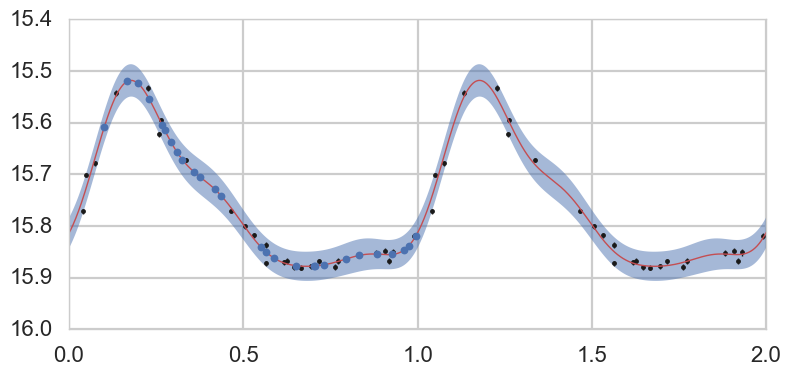

23.6617193389 23


In [28]:
# initial time range
#time_obs = np.linspace(time.min(), time.min()+6., 100000)
# HiTS sampling function
# hits_time = time_obs[HiTS_sample_func(time_obs)]
n = np.random.choice(range(49))
hits_time = time_all[n][:,1]
# predicted magnitude for GP
mag_obs = GP_fit(time, mag, err, T, T_1=T, plot=True, x_pred=hits_time)
# scale to HiTS depth and add empirical uncertainties
hits_mag, hits_noise_mag, hits_err = HiTS_depth_noise(mag_obs)
if hits_mag.mean() < 20:
    size = int(len(hits_time)*np.random.uniform(.95,1., size=1))
elif hits_mag.mean() < 22 and hits_mag.mean() > 20:
    size = int(len(hits_time)*np.random.uniform(.8,1., size=1))
else:
    size = int(len(hits_time)*np.random.uniform(.65,1., size=1))  
print hits_mag.mean(), size
idx = np.sort(np.random.choice(np.arange(len(hits_time)),
                       size=size, replace=False))
hits_time = hits_time[idx]
hits_mag = hits_mag[idx]
hits_noise_mag = hits_noise_mag[idx]
hits_err = hits_err[idx]

(26,)


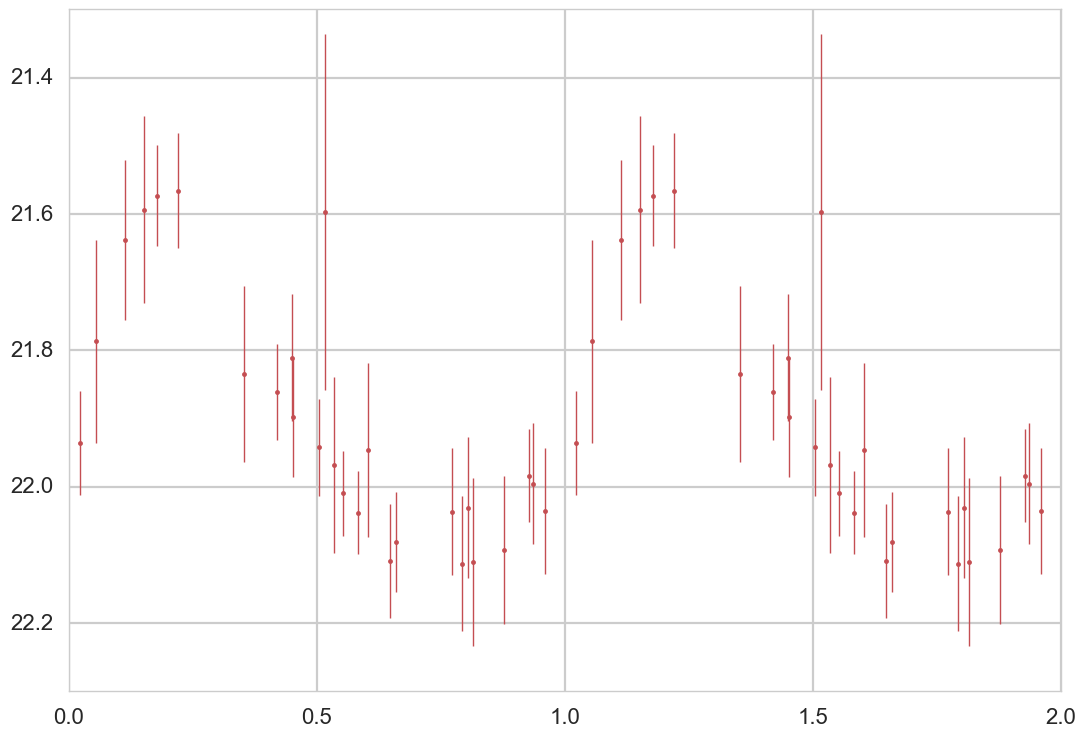

In [25]:
print hits_time.shape

phase = np.mod(hits_time, T) / T
sort_idx = np.argsort(phase)

hits_PHASE = phase[sort_idx]
hits_MAG = hits_mag[sort_idx]
hits_noise_MAG = hits_noise_mag[sort_idx]
hits_ERR = hits_err[sort_idx]

hits_MAG = np.concatenate([hits_MAG,hits_MAG])
hits_noise_MAG = np.concatenate([hits_noise_MAG,hits_noise_MAG])
hits_PHASE = np.concatenate([hits_PHASE,hits_PHASE+1])
hits_ERR = np.concatenate([hits_ERR,hits_ERR])

#plt.errorbar(hits_PHASE, hits_MAG, yerr=hits_ERR, fmt='k.', ms=7, lw=1,alpha=1)
plt.errorbar(hits_PHASE, hits_noise_MAG, yerr=hits_ERR, fmt='r.', ms=7, lw=1,alpha=1)
plt.gca().invert_yaxis()

In [15]:
all_dsct, all_per = [], []
for k in range(5000):
    T_1 = np.random.uniform(0.02, 0.33)
    print '\r',k, T_1,

    # HiTS sampling function
    #hits_time = time_obs[HiTS_sample_func(time_obs)]
    n = np.random.choice(range(49))
    hits_time = time_all[n][:,1]
    # predicted magnitude for GP
    mag_obs = GP_fit(time, mag, err, T, T_1=T_1, plot=False, x_pred=hits_time)
    # scale to HiTS depth and add empirical uncertainties
    hits_mag, hits_noise_mag, hits_err = HiTS_depth_noise(mag_obs)
    if hits_mag.mean() < 20:
        size = int(len(hits_time)*np.random.uniform(.95,1., size=1))
    elif hits_mag.mean() < 22 and hits_mag.mean() > 20:
        size = int(len(hits_time)*np.random.uniform(.85,1., size=1))
    else:
        size = int(len(hits_time)*np.random.uniform(.75,1., size=1))  
    print hits_mag.mean(), size,
    idx = np.sort(np.random.choice(np.arange(len(hits_time)),
                       size=size, replace=False))
    hits_time = hits_time[idx]
    hits_mag = hits_mag[idx]
    hits_noise_mag = hits_noise_mag[idx]
    hits_err = hits_err[idx]

    df = pd.DataFrame(np.array([hits_time, hits_noise_mag, hits_err]).T,
                      columns=['MJD','MAG_KRON','MAGERR_KRON'])
    path = '%s/synt_lcs/dsct_%i_%.6f.csv' % (mainpath,k,T_1)
    df.to_csv(path)
    all_dsct.append(df)
    all_per.append(T_1)

4999 0.0497187934158 23.7598265174 25


## FATS features

In [16]:
import FATS
import P4J
from gatspy.periodic import LombScargle

In [17]:
def calculate_FATS_features(id_lc, lc_g, verbose=True):

    time, mag, error = np.array(lc_g['MJD'].values), np.array(lc_g['MAG_KRON'].values),\
                       np.array(lc_g['MAGERR_KRON'].values)
    lc = np.array([mag, time, error])

    if verbose: print 'N Epochs? %i' % len(lc[0])
    # Available imput data
    fats = FATS.FeatureSpace(Data = ['magnitude','time', 'error'],
                                excludeList = ['StetsonJ', 'StetsonL', 'Eta_color', 'Q31_color', 'Color'])
    feat = fats.calculateFeature(lc)
    result = feat.result(method = 'dict')
    result_df = pd.DataFrame.from_dict(result, orient = 'index')
    result_df.columns = [id_lc]
    return result_df.T

def P4J_period(lc_g):

    try:
        time, mag, error = np.array(lc_g['MJD'].values), np.array(lc_g['MAG_KRON'].values),\
                           np.array(lc_g['MAGERR_KRON'].values)

        WMCC_model = P4J.periodogram(M=1, method='WMCC')
        WMCC_model.fit(time, mag-np.mean(mag), error)

        per_f = np.max(time) - np.min(time)
        freq, obj = WMCC_model.grid_search(fmin=1/30., fmax=1/.01, fres_coarse=2, fres_fine=0.05, n_local_max=10)
        fbest = WMCC_model.get_best_frequency()
        WMCC_model.fit_extreme_cdf(n_bootstrap=40, n_frequencies=40)
        confidence_best_freq = WMCC_model.get_confidence(fbest[1])
        return 1./fbest[0], confidence_best_freq
    except:
        print 'P4J fail calculating period...'
        return None, None

def gatspy_period(lc_g):

    time, mag, error = np.array(lc_g['MJD'].values), np.array(lc_g['MAG_KRON'].values),\
                       np.array(lc_g['MAGERR_KRON'].values)

    per_f = (np.max(time) - np.min(time))*10
    periods = np.linspace(.01, per_f, 10000)

    model = LombScargle(fit_offset=True).fit(time, mag, error)
    power = model.score(periods)

    best_per = periods[np.argmax(power)]

    return best_per

def preprocess_lc(lc, min_mag=15.):
    #time, mag, error = np.array(lc_g['MJD'].quantity), np.array(lc_g['MAG_KRON'].quantity),\
    #                   np.array(lc_g['MAGERR_KRON'].quantity)
    # remove saturated points
    #print 'Original size: %i |' % len(lc),
    lc = lc[lc['MAG_KRON'].values >= min_mag]

    # sigma clipping
    filtered_data = sigma_clip(np.array(lc['MAG_KRON'].values), sigma=4, iters=1, cenfunc=np.mean, copy=False)
    lc = lc[~filtered_data.mask]
    #print ' clipped: %i |' % np.sum(filtered_data.mask),
    #print 'Final size: %i' % len(lc)

    return lc

def get_features(data):
    per = data[0]
    lc = data[1]
    k = data[2]
    lc = preprocess_lc(lc)
    id_lc = 'dsct_%.6f' % (per)
    print '\r LC %i: %s...' % (k,id_lc)
    featur = calculate_FATS_features(id_lc, lc, verbose=False)
    if True:
        period, conf = P4J_period(lc)
        featur['PeriodWMCC'] = period
        featur['PeriodWMCC_conf'] = conf

    if True:
        period = gatspy_period(lc)
        featur['PeriodGLS'] = period
    featur['Real_Period'] = per
    return featur

In [18]:
print len(all_dsct), len(all_per)

5000 5000


In [20]:
from multiprocessing import Pool

In [21]:
p = Pool(processes=4)
frames = p.map(get_features, zip(all_per, all_dsct, range(len(all_per))))

 LC 0: dsct_0.201739...


/Users/jorgetil/miniconda2/lib/python2.7/site-packages/FATS-1.3.6-py2.7.egg/FATS/FeatureFunctionLib.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return (np.median(sorted_mag[-math.ceil(0.05 * N):]) -
/Users/jorgetil/miniconda2/lib/python2.7/site-packages/FATS-1.3.6-py2.7.egg/FATS/FeatureFunctionLib.py:30: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  np.median(sorted_mag[0:math.ceil(0.05 * N)])) / 2.0
/Users/jorgetil/miniconda2/lib/python2.7/site-packages/FATS-1.3.6-py2.7.egg/FATS/FeatureFunctionLib.py:543: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  F_40_60 = sorted_data[F_60_index] - sorted_data[F_40_index]
/Users/jorgetil/miniconda2/lib/python2.7/site-packages/FATS-1.3.6-py2.7.egg/FATS/FeatureFunctionLib.py:544: VisibleDeprecationWarning: using a non-integer number i

 LC 313: dsct_0.258432...


/Users/jorgetil/miniconda2/lib/python2.7/site-packages/FATS-1.3.6-py2.7.egg/FATS/lomb.py:151: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  wk1 = wk1[1:nout+1]
/Users/jorgetil/miniconda2/lib/python2.7/site-packages/FATS-1.3.6-py2.7.egg/FATS/lomb.py:152: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  wk2 = wk2[1:nout+1]
/Users/jorgetil/miniconda2/lib/python2.7/site-packages/scipy/optimize/_minimize.py:394: RuntimeWarning: Method nelder-mead cannot handle constraints nor bounds.
  RuntimeWarning)
/Users/jorgetil/miniconda2/lib/python2.7/site-packages/FATS-1.3.6-py2.7.egg/FATS/FeatureFunctionLib.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return (np.median(sorted_mag[-math.ceil(0.05 * N):]) -
/Users/jorgetil/miniconda2/lib/python2.7/site-packages/FATS-1.3.6-py2.7.egg/FATS/Fe

 LC 626: dsct_0.041155...


/Users/jorgetil/miniconda2/lib/python2.7/site-packages/FATS-1.3.6-py2.7.egg/FATS/FeatureFunctionLib.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return (np.median(sorted_mag[-math.ceil(0.05 * N):]) -
/Users/jorgetil/miniconda2/lib/python2.7/site-packages/FATS-1.3.6-py2.7.egg/FATS/FeatureFunctionLib.py:30: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  np.median(sorted_mag[0:math.ceil(0.05 * N)])) / 2.0
/Users/jorgetil/miniconda2/lib/python2.7/site-packages/FATS-1.3.6-py2.7.egg/FATS/FeatureFunctionLib.py:543: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  F_40_60 = sorted_data[F_60_index] - sorted_data[F_40_index]
/Users/jorgetil/miniconda2/lib/python2.7/site-packages/FATS-1.3.6-py2.7.egg/FATS/FeatureFunctionLib.py:544: VisibleDeprecationWarning: using a non-integer number i

 LC 939: dsct_0.093291...


/Users/jorgetil/miniconda2/lib/python2.7/site-packages/FATS-1.3.6-py2.7.egg/FATS/lomb.py:152: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  wk2 = wk2[1:nout+1]
/Users/jorgetil/miniconda2/lib/python2.7/site-packages/scipy/optimize/_minimize.py:394: RuntimeWarning: Method nelder-mead cannot handle constraints nor bounds.
  RuntimeWarning)
/Users/jorgetil/miniconda2/lib/python2.7/site-packages/FATS-1.3.6-py2.7.egg/FATS/FeatureFunctionLib.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return (np.median(sorted_mag[-math.ceil(0.05 * N):]) -
/Users/jorgetil/miniconda2/lib/python2.7/site-packages/FATS-1.3.6-py2.7.egg/FATS/FeatureFunctionLib.py:30: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  np.median(sorted_mag[0:math.ceil(0.05 * N)])) / 2.0
/Users/jorgetil/miniconda2/lib/python2

 LC 627: dsct_0.161727...
 LC 940: dsct_0.154465...
 LC 314: dsct_0.296694...
 LC 1: dsct_0.042546...
 LC 628: dsct_0.038778...
 LC 941: dsct_0.128396...
 LC 2: dsct_0.220840...
 LC 315: dsct_0.061593...
 LC 629: dsct_0.049767...
 LC 942: dsct_0.084666...
 LC 3: dsct_0.205879...
 LC 316: dsct_0.162317...
 LC 4: dsct_0.274499...
 LC 630: dsct_0.075254...
 LC 943: dsct_0.128116...
 LC 317: dsct_0.043981...
 LC 944: dsct_0.146073...
 LC 5: dsct_0.183534...
 LC 318: dsct_0.102802...
 LC 631: dsct_0.037750...
 LC 945: dsct_0.062188...
 LC 6: dsct_0.061691...
 LC 632: dsct_0.215123...
 LC 319: dsct_0.116933...
 LC 946: dsct_0.277784...
 LC 7: dsct_0.287120...
 LC 633: dsct_0.243330...
 LC 320: dsct_0.201084...
 LC 947: dsct_0.174638...
 LC 8: dsct_0.268625...
 LC 634: dsct_0.123755...
 LC 321: dsct_0.289424...
 LC 948: dsct_0.279478...
 LC 9: dsct_0.086246...
 LC 635: dsct_0.152973...
 LC 322: dsct_0.099098...
 LC 10: dsct_0.148400...
 LC 949: dsct_0.274172...
 LC 636: dsct_0.308713...
 LC 3

/Users/jorgetil/miniconda2/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/jorgetil/miniconda2/lib/python2.7/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


TypeError: ufunc 'bitwise_or' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

 LC 1252: dsct_0.199295...


In [ ]:
fats_feat = pd.concat(frames, axis = 0)
fats_feat = fats_feat[np.sort(fats_feat.columns.values)]
fats_feat['Var_Type'] = 'DSCT'
fats_feat[['Real_Period','Var_Type']].tail()

In [ ]:
fats_feat.to_csv('%s/tables/Syntectic_DSCT_features_noise.csv' % (mainpath))

In [129]:
fats_feat_good = fats_feat.query('Period_fit < .5')

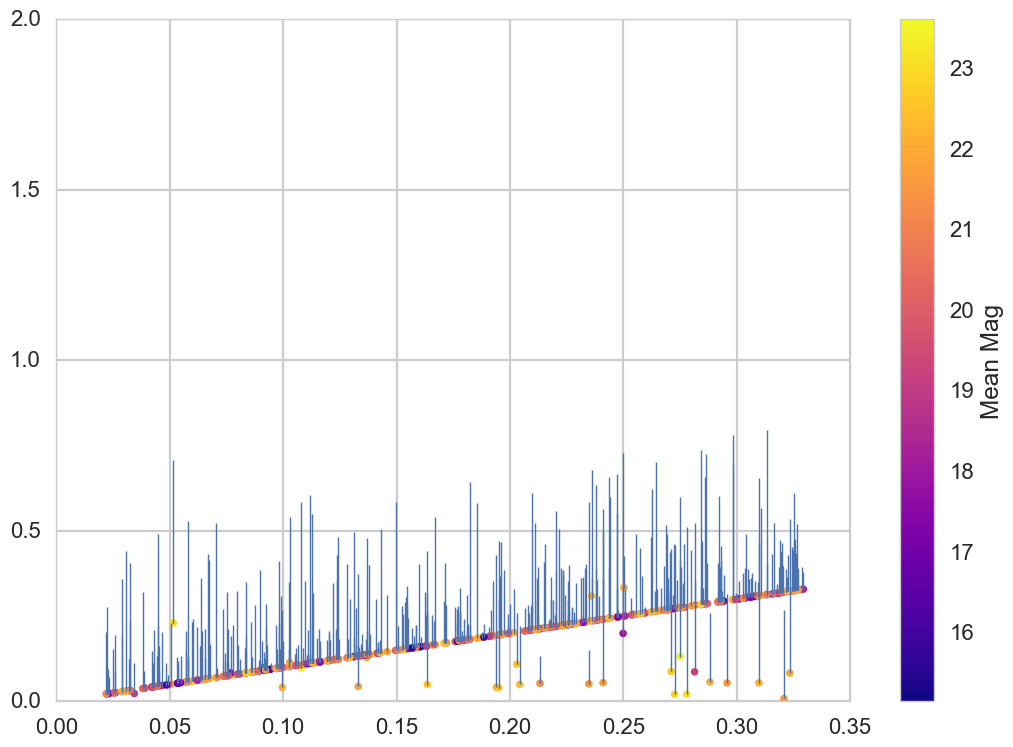

In [130]:
plt.figure()
plt.errorbar(fats_feat_good.Real_Period.values, fats_feat_good.PeriodLS.values,
             yerr=[fats_feat_good.Period_fit.values*0. , fats_feat_good.Period_fit.values],ms=1, fmt='.', lw=1)
plt.scatter(fats_feat_good.Real_Period.values, fats_feat_good.PeriodLS.values,
                c=fats_feat_good.Mean.values, linewidth=0, s=30, alpha=1.,
                cmap=plt.cm.plasma, label='unlabeled')
plt.colorbar(label='Mean Mag')
plt.ylim(0,2)
plt.show()

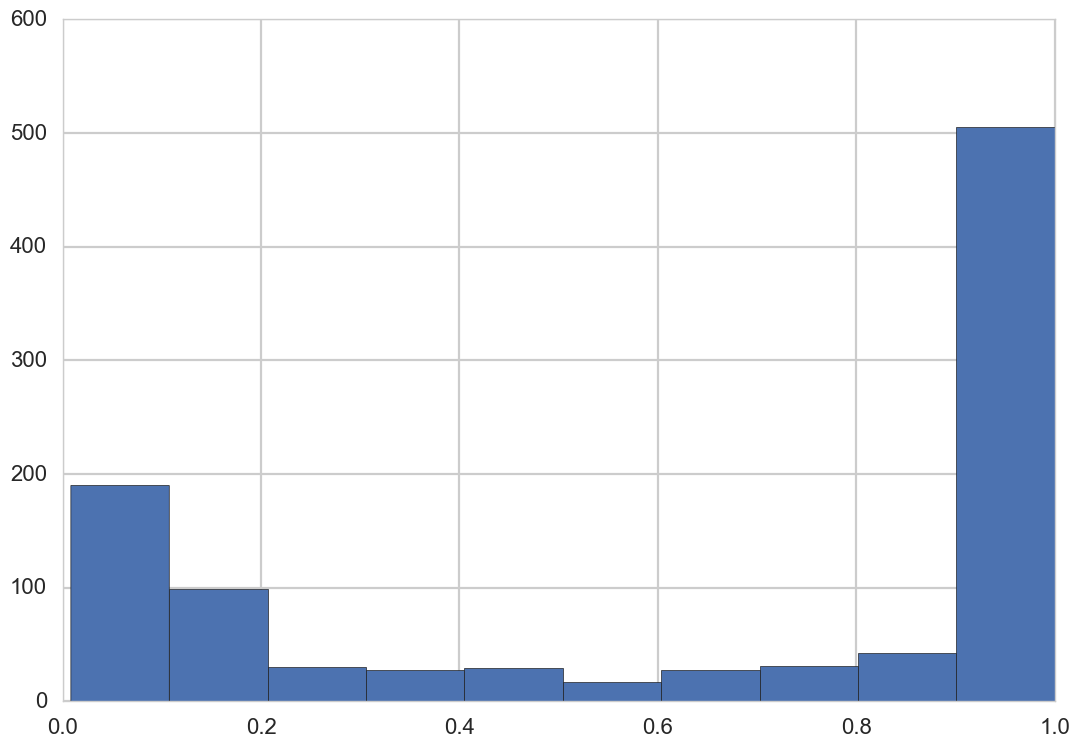

In [131]:
plt.hist(fats_feat.Period_fit.values)
plt.show()